# Big data - Весна 2024 "Сферический Велопрокат в Вакууме"

## Задание

>Учащимся выдается датасет с многолетними накопленными историческими
>данными о поездках велопроката Divvy Bikes. На основании этого датасета
>нужно оценить объем рынка и характер его динамики, а затем разработать
>модель юнит-экономики поездки для различных сценариев использования
>сервиса: разовая покупка, месячная подписка и т.д.
>Тезисный план:
>1. Разведочный анализ датасета
>2. Подготовка аналитических витрин данных
>3. Расширенный анализ витрин с целью оценки объема рынка, характера
>динамики и прогнозирования роста
>4. Разработка модели юнит-экономики поездки
>5. Анализ чувствительности по основным параметрам модели
>6. Визуализация ключевых показателей
>7. Подготовка рассказа, презентации и дашборда с основными
результатами и выводами

## Импорт Библиотек и загрузка датасетов

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, chi2_contingency, ttest_ind, mannwhitneyu, shapiro, permutation_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

C:\Users\gosha\AppData\Local\Temp\ipykernel_7868\1133677404.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("202403-divvy-tripdata.csv", sep=",")

## Предобработка данных

In [3]:
def check_data(data_df: pd.DataFrame):

    """
        Функция для просмотра сводной информации о датасете
    """
    print ('\033[1m' + 'Сводная информация об исходных данных'+ '\033[0m')
    print(data_df.info())
    print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1)) # пропущенные ячейки
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк, содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые десять строк датасета'+ '\033[0m')
    display(data_df.head(10))
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
    
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T) 
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориальному признаку без учета id:'+ '\033[0m')    
    df_object = data_df.select_dtypes(include='object').columns
    
    for i in df_object:
        if data_df[i].nunique() > 10:
            continue
        print('\033[1m' + ('_' * 10) + '\033[0m')
        display(data_df[i].value_counts())


In [4]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количественных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows, 2, figsize=(8, 16))
    f.tight_layout()
    f.set_figheight(15)
    f.set_figwidth(8)
    plt.rcParams.update({'font.size': 12})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=16, ax = ax[i, 0])                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
        ax[i, 1].set_ylabel("")
    plt.suptitle("Гистограмма и ящик с усами для количественных данных", fontsize=22, y=1.01)
    plt.show()

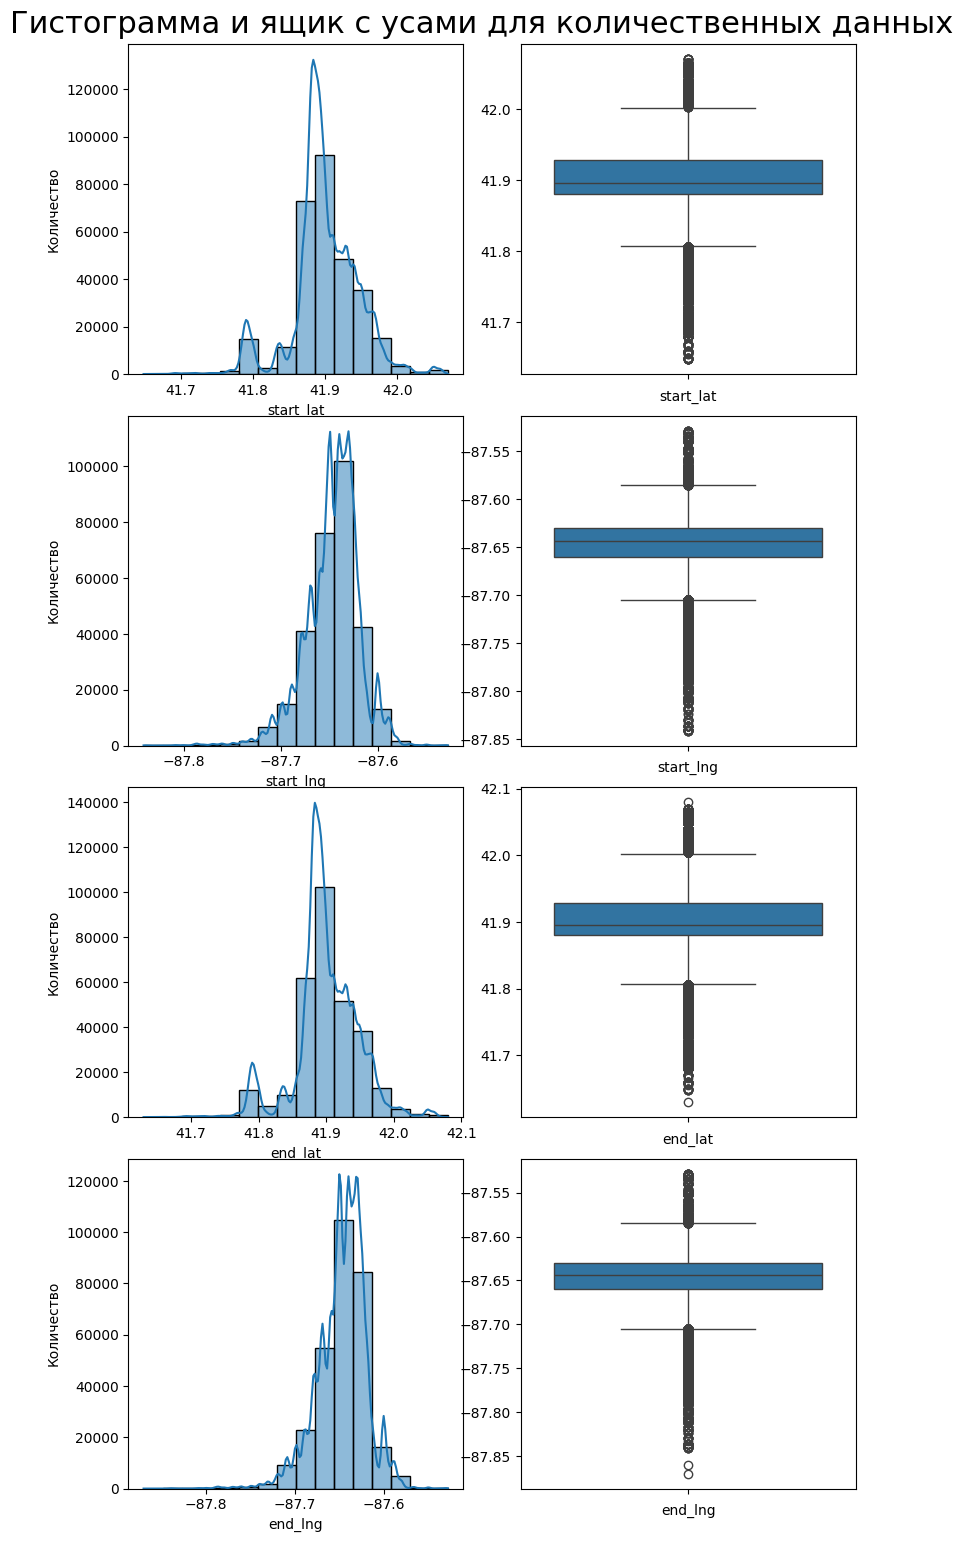

In [5]:
plot_hist(df, ["start_lat", "start_lng", "end_lat", "end_lng"])

In [6]:
check_data(df)

Сводная информация об исходных данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301687 entries, 0 to 301686
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             301687 non-null  object 
 1   rideable_type       301687 non-null  object 
 2   started_at          301687 non-null  object 
 3   ended_at            301687 non-null  object 
 4   start_station_name  257432 non-null  object 
 5   start_station_id    257432 non-null  object 
 6   end_station_name    254547 non-null  object 
 7   end_station_id      254547 non-null  object 
 8   start_lat           301687 non-null  float64
 9   start_lng           301687 non-null  float64
 10  end_lat             301291 non-null  float64
 11  end_lng             301291 non-null  float64
 12  member_casual       301687 non-null  object 
dtypes: float64(4), object(9)
memory usage: 29.9+ MB
None
(301687, 13)

Проверка пропусков
Количество

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,64FBE3BAED5F29E6,electric_bike,2024-03-05 18:33:11,2024-03-05 18:51:48,NaN,NaN,NaN,NaN,41.94,-87.65,41.96,-87.65,member
1,9991629435C5E20E,electric_bike,2024-03-06 17:15:14,2024-03-06 17:16:04,NaN,NaN,NaN,NaN,41.91,-87.64,41.91,-87.64,member
2,E5C9FECD5B71BEBD,electric_bike,2024-03-06 17:16:36,2024-03-06 17:19:28,NaN,NaN,NaN,NaN,41.91,-87.64,41.92,-87.64,member
3,4CEA3EC8906DAEA8,electric_bike,2024-03-03 22:55:54,2024-03-03 22:58:08,NaN,NaN,NaN,NaN,41.90,-87.63,41.89,-87.63,member
4,77266B408503C55F,electric_bike,2024-03-17 11:15:18,2024-03-17 11:31:18,NaN,NaN,NaN,NaN,41.93,-87.70,41.93,-87.72,member
5,E81C25D251767135,electric_bike,2024-03-29 14:40:49,2024-03-29 14:58:11,NaN,NaN,NaN,NaN,41.93,-87.70,41.95,-87.68,member
6,797881859A9C90EF,electric_bike,2024-03-01 17:23:58,2024-03-01 17:34:01,NaN,NaN,NaN,NaN,41.94,-87.64,41.95,-87.65,member
7,07D8E2E4CF03F1D8,electric_bike,2024-03-01 00:15:03,2024-03-01 00:18:56,NaN,NaN,NaN,NaN,41.91,-87.63,41.92,-87.64,member
8,4AC53C43066B3E66,electric_bike,2024-03-25 17:58:35,2024-03-25 18:02:05,NaN,NaN,NaN,NaN,41.84,-87.62,41.85,-87.62,member
9,1F2418001E121479,electric_bike,2024-03-01 09:36:51,2024-03-01 10:19:48,NaN,NaN,NaN,NaN,41.75,-87.67,41.75,-87.67,member



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
start_lat,301687.0,41.900193,0.045687,41.648501,41.880000,41.895634,41.928773,42.070000
start_lng,301687.0,-87.646736,0.027216,-87.841110,-87.660000,-87.643320,-87.629912,-87.528232
end_lat,301291.0,41.900595,0.045820,41.630000,41.880000,41.895769,41.929143,42.080000
end_lng,301291.0,-87.646933,0.027379,-87.870000,-87.660274,-87.643353,-87.629912,-87.528232



Описание категориальных данных:


,count,unique,top,freq
ride_id,301687,301687,64FBE3BAED5F29E6,1
rideable_type,301687,2,electric_bike,153103
started_at,301687,272545,2024-03-12 16:54:33,6
ended_at,301687,273219,2024-03-29 15:28:18,9
start_station_name,257432,1145,Streeter Dr & Grand Ave,2581
start_station_id,257432,1128,13022,2581
end_station_name,254547,1140,Streeter Dr & Grand Ave,2565
end_station_id,254547,1123,13022,2565
member_casual,301687,2,member,219137



Вывод уникальных значений по каждому категориальному признаку без учета id:
__________


rideable_type
electric_bike    153103
classic_bike     148584
Name: count, dtype: int64

__________


member_casual
member    219137
casual     82550
Name: count, dtype: int64

**Категориальные столбцы с фиксированными возможными значениями проверены** в функции и дальнейшей обработки не потребуют

Важное замечание: мы не будем отбрасывать выбросы с помощью с помощью перцентилей в столбце со временем поездки так как столбец имеет экспоненциалльное распределение, но и не учитывать его (то-есть перейти к более большим величинам мы не можем потому что большее число клиентов пользуются велосипедами на короткий промежуток времени (меньше часа)) мы не можем

### ride_id

Уникальный идентификатор каждой поездки

In [7]:
df["ride_id"].duplicated().sum()

0

### started_at и ended_at

**started_at** : дата и время начала поездки  
**ended_at** : дата и время окончания поездки

In [8]:
# Исправляю формат данных столбцов started_at и ended_at на дату
df["started_at"] = pd.to_datetime(df["started_at"])
df["ended_at"] = pd.to_datetime(df["ended_at"])
# df.info()

In [9]:
df["ride_duration"] = (df["ended_at"] - df["started_at"]) # столбец содержащий время поездки

В датасете имеются ошибки с датой начала и конца поездки, а также хоть и на сайте написано что данные предобрабатываются от случайного срабатывания (человек пытался переустановить велосипед на стоянку чтобы убедиться в его безопасности или это может быть ложный старт) по факту в датасете их полным полно

In [32]:
print(df.shape[0])
bigger = df[df["started_at"] > df["ended_at"]]
lower_1m = df[df["ride_duration"] < pd.Timedelta(minutes=1)]
# print(np.percentile(df["ride_duration"].apply(lambda x: x.total_seconds()/60), 0.03)) еще нужно подумать...
df = df[df["ride_duration"] > pd.Timedelta(minutes=1)]
df = df[df["started_at"] < df["ended_at"]]
df[df["ride_duration"] > pd.Timedelta(hours=1)].shape # больше часа на велосипеде катаются всего 5000 записей из 300 тысяч

301291
0.0


(5059, 17)

In [11]:
df["day"] = df["started_at"].apply(lambda x: x.day)
df["month"] = df["started_at"].apply(lambda x: x.month)
df["year"] = df["started_at"].apply(lambda x: x.year)

In [12]:
df["month"].unique().size > 1

False

In [13]:
df["year"].unique().size > 1

False

### Названия и id точки начала поездки и конца

- start_station_name: название станции, с которой началось путешествие
- start_station_id: уникальный идентификатор станции, с которой началась поездка
- end_station_name: название станции, на которой закончилась поездка
- end_station_id: уникальный идентификатор станции, на которой закончилась поездка

In [14]:
data = df[["start_station_name", "start_station_id", "end_station_name", "end_station_id"]]
print(data.isna().sum())
missed_cells = data.isna().sum().sum()/(data.shape[0]*(data.shape[1]))
print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')

start_station_name    44255
start_station_id      44255
end_station_name      47140
end_station_id        47140
dtype: int64
Доля пропусков: 15.1%


При исследовании данных столбцов было замечено **очень много пропусков** (15% от объема данных)

Посторили график и обнаружили зависимость между отсутствующими значениями и типом арендуемого велосипеда

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
ride_duration         0
day                   0
month                 0
year                  0
dtype: int64
230278


Text(0.5, 0.98, 'Сравнение данных до\nи после удаления')

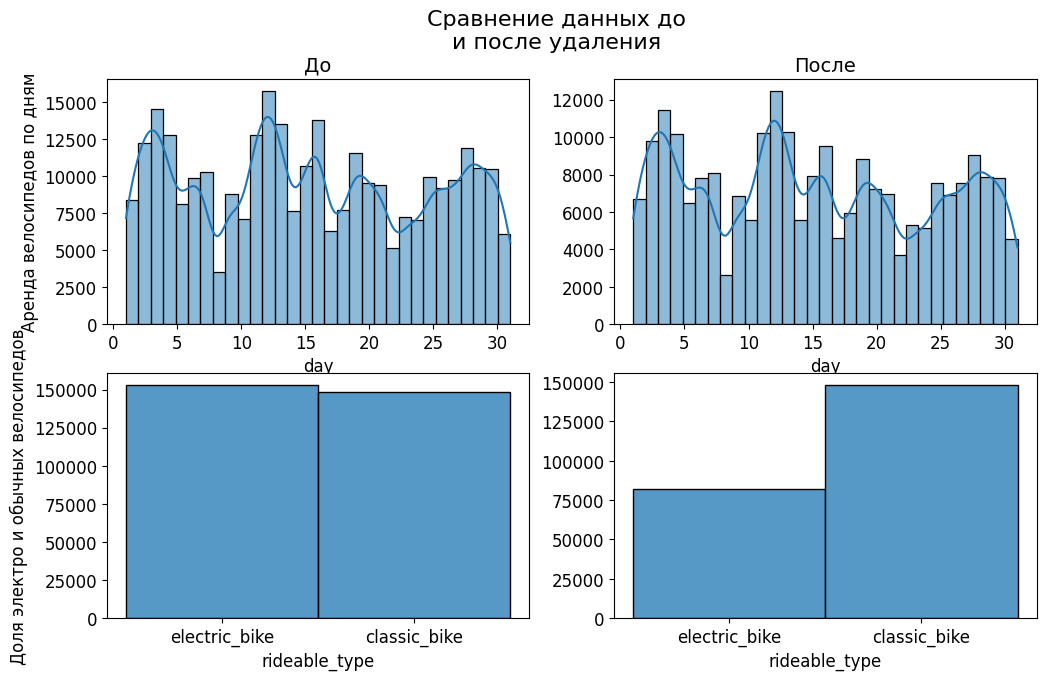

In [15]:
max_day = sorted(df["day"].unique())[-1] # переменная содержащая цифру по счету максимального дня в месяце

# print(df[["start_station_name", "start_lat", "start_lng", "end_lat", "end_lng"]].groupby(["start_station_name"]).head(2))

fig, ax = plt.subplots(2, 2, figsize=(12, 7))

sns.histplot(df["day"], kde=True, bins=max_day, ax=ax[0, 0])
ax[0, 0].set_ylabel("Аренда велосипедов по дням")
sns.histplot(df["rideable_type"], ax=ax[1, 0])
ax[1, 0].set_ylabel("Доля электро и обычных велосипедов")
ax[0, 0].set_title("До", fontsize=14)

data = df.dropna()
print(data.isna().sum())
print(data.shape[0])

sns.histplot(data["day"], kde=True, bins=max_day, ax=ax[0, 1])
sns.histplot(data["rideable_type"], ax=ax[1, 1])
ax[1, 1].set_ylabel("")
ax[0, 1].set_ylabel("")
ax[0, 1].set_title("После", fontsize=14)
plt.suptitle("Сравнение данных до\nи после удаления", fontsize=16)
# plt.savefig("Result_of_analisys_nan")

По графикам видно что ошибки в данных связаны с арендой электровелосипедов и если удалить эти данные мы потеряем львиную долю рынка электровелосепедов и в следствии репрезентативность выборки  
**Данные нужно восстанавливать**  
Либо удалять равную долю данных по обычным велосипедам

Если посмотреть на распределение долей между обычными и электро- велосипедами то можно заметить сильный скос (после удаления данных в которых есть пробелы) в сторону обычных велосипедов, а это значит что большинство записей с пропусками это электровелосипеды

Допустим

**А почему так происходит?**  
Есть довольно простой ответ  

Если посмотреть по карте то можно заметить что очень часто велосипеды оставляют просто вне стоянки где попало

![Отдельно стоящие велосипеды](./Отдельные_велосипеды.png)

Зеленое - Стоянки для велосипедов  
Красное - электро-велосипеды (ebike)  
**Что с этим делать?**  
Один из простых вариантов **просто заполнить пропуски меткой что данные велосипеды взяты и припаркованы вне стоянки**

In [16]:
df.fillna({"start_station_name": "droped", 
           "end_station_name": "droped",
           "start_station_id": "droped",
           "end_station_id": "droped"}, inplace=True)

df[["start_station_name", "start_station_id", "end_station_name", "end_station_id"]].isna().sum()

start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
dtype: int64

### Координаты начала и конца поездки

- start_lat: широта начальной станции
- start_lng: долгота начальной станции
- end_lat: широта конечной станции
- end_lng: долгота конечной станции

**Задание: разобраться с пропусками в координатах конца поездки**  
У нас есть данные с временем аренды больше дня у которых отсутствует точка конца поездки  
Это ошибка в данных, но как это можно объяснить?

In [17]:
data = df[df["end_lat"].isna() == True]
print(data.sort_values(by="ride_duration", ascending=False).head())

                 ride_id rideable_type          started_at  \
159826  2E7A26B0B6513B10  classic_bike 2024-03-09 07:48:01   
234337  446B8A4213AAD837  classic_bike 2024-03-09 11:40:48   
125704  5C466397FA10F4E5  classic_bike 2024-03-09 17:30:58   
150450  88D00324B450377C  classic_bike 2024-03-09 23:17:38   
113623  A243363027749E4B  classic_bike 2024-03-09 10:52:26   

                  ended_at         start_station_name start_station_id  \
159826 2024-03-10 09:47:57      Green St & Madison St     TA1307000120   
234337 2024-03-10 13:40:43  Franklin St & Chicago Ave            13017   
125704 2024-03-10 19:30:52    Streeter Dr & Grand Ave            13022   
150450 2024-03-11 01:17:29     Jeffery Blvd & 76th St     KA1503000028   
113623 2024-03-10 12:52:14     Clinton St & Tilden St            13037   

       end_station_name end_station_id  start_lat  start_lng  end_lat  \
159826           droped         droped  41.881859 -87.649264      NaN   
234337           droped         drop

In [19]:
# sns.bar(data["rideable_type"])

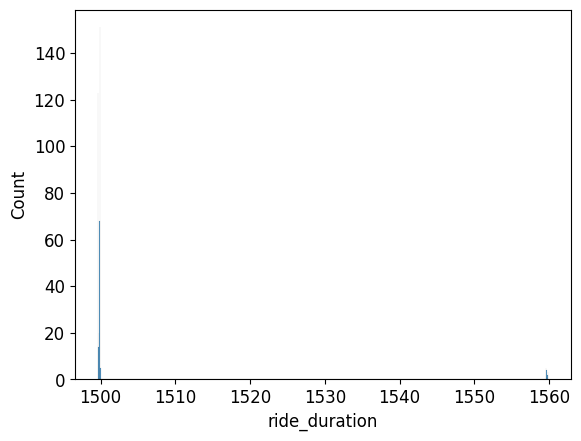

In [20]:
sns.histplot(data["ride_duration"].apply(lambda x: x.total_seconds()/60))
plt.show()

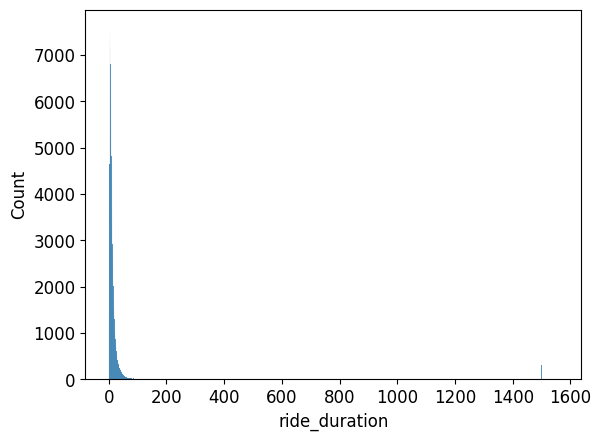

                 ride_id rideable_type          started_at  \
159826  2E7A26B0B6513B10  classic_bike 2024-03-09 07:48:01   
234337  446B8A4213AAD837  classic_bike 2024-03-09 11:40:48   
125704  5C466397FA10F4E5  classic_bike 2024-03-09 17:30:58   
150450  88D00324B450377C  classic_bike 2024-03-09 23:17:38   
113623  A243363027749E4B  classic_bike 2024-03-09 10:52:26   

                  ended_at         start_station_name start_station_id  \
159826 2024-03-10 09:47:57      Green St & Madison St     TA1307000120   
234337 2024-03-10 13:40:43  Franklin St & Chicago Ave            13017   
125704 2024-03-10 19:30:52    Streeter Dr & Grand Ave            13022   
150450 2024-03-11 01:17:29     Jeffery Blvd & 76th St     KA1503000028   
113623 2024-03-10 12:52:14     Clinton St & Tilden St            13037   

       end_station_name end_station_id  start_lat  start_lng  end_lat  \
159826           droped         droped  41.881859 -87.649264      NaN   
234337           droped         drop

In [21]:
sns.histplot(df["ride_duration"].apply(lambda x: x.total_seconds()/60))
plt.show()
print(df.sort_values(by="ride_duration", ascending=False).head())

Вероятнее всего это что-то одно либо все сразу:
- поездки сотрудников (хотя указано что данные от этого предобработаны)
- украденные велосипеды которые куда нибудь укатили и разобрали на запчасти 
- с велосипедами произошел несчастный случай (велосипед утопили, человека на велосипеде сбили и так далее)

**Это мы отфильтровываем и в конечный датасет не берем**

In [22]:
df.dropna(inplace=True)
# df.isna().sum()

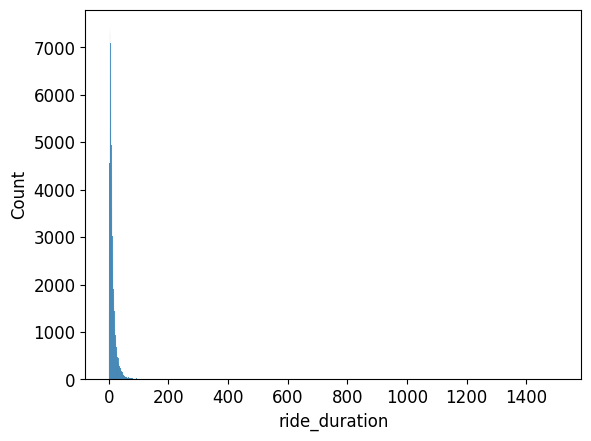

                 ride_id rideable_type          started_at  \
55451   7A5CAAC52FAE9E95  classic_bike 2024-03-09 16:58:39   
237549  927277B01FED35FB  classic_bike 2024-03-03 09:49:12   
232913  C1C9EBE54C3DA9C5  classic_bike 2024-03-20 07:59:19   
121124  520B17968416151C  classic_bike 2024-03-30 09:59:01   
233904  E1A9DE4368A49C1A  classic_bike 2024-03-25 15:54:22   

                  ended_at                  start_station_name  \
55451  2024-03-10 18:08:01             Talman Ave & Addison St   
237549 2024-03-04 10:49:09      Southport Ave & Wellington Ave   
232913 2024-03-21 08:59:15           Ashland Ave & Division St   
121124 2024-03-31 10:58:56  DuSable Lake Shore Dr & North Blvd   
233904 2024-03-26 16:54:16               Wabash Ave & Adams St   

       start_station_id         end_station_name end_station_id  start_lat  \
55451             15632  Talman Ave & Addison St          15632  41.946636   
237549     TA1307000006                   droped         droped  41.935775

In [23]:
sns.histplot(df["ride_duration"].apply(lambda x: x.total_seconds()/60))
plt.show()
print(df.sort_values(by="ride_duration", ascending=False).head())

In [29]:
# df[df["ride_duration"] > pd.Timedelta(hours=10)].head(20)

Получшившееся в результате очистки максимальное значение времени поездки очень даже согласовывается с его данными так как это может быть самый обыкновыенный пользователь который взял велосипед покататься на день возле дома, покатался, где то переночевал и вернулся обратно домой

### Обогащение данных

In [25]:
# stations = df.groupby(["start_station_name"])[["start_station_id", "start_lat", "start_lng"]].head(5).sort_values(by="start_station_id")
# stations

In [40]:
df["day_of"] = df["started_at"].apply(lambda x: x.day_name())
# df["day_of"].head()
df["is_hol"] = df["started_at"].apply(lambda x: x.day_of_week in (5, 6))
# df[["day_of", "is_hol"]][df["is_hol"]].head(40)

,day_of,is_hol
3,Sunday,True
4,Sunday,True
18,Sunday,True
22,Sunday,True
23,Sunday,True
24,Sunday,True
25,Saturday,True
27,Sunday,True
47,Sunday,True
49,Saturday,True


**Вопрос: У нас есть равные и больше даты старта и конца   
Это все ошибки произошедшие по тем или иным причинам  
Стоит ли это удалять  
Это может быть не ошибка в данных, а может быть пользователь просто взял и сразу поставил велосипед**  
**UPD**: Это ошибка в нормальной работе системы а значит скорее всего это будет шумом для наших метрик  
Проанализируем и удалим

## Разведочный анализ

**Попробуем заполнить пропуски в данных**

**Проверил ошибки в датах**

In [26]:
# df.to_csv("New.csv", index=False)